In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn_pandas import DataFrameMapper, gen_features

from utils.common import compress_read, set_pandas_option, df_statistic, df_hist

In [2]:
set_pandas_option()
train = compress_read('data/train.csv')
pred = compress_read('data/test.csv')
sample_submission = compress_read('data/sample_submission.csv')

In [3]:
df_statistic(train)

,Feature,Type,Unique Values,Not Null Count,Null Value Percentage,Biggest Category Percentage
0,Id,int64,1460,1460,0.000000,0.068493
1,MSSubClass,int64,15,1460,0.000000,36.712329
2,MSZoning,object,5,1460,0.000000,78.835616
3,LotFrontage,float64,110,1201,17.739726,17.739726
4,LotArea,int64,1073,1460,0.000000,1.712329
5,Street,object,2,1460,0.000000,99.589041
6,Alley,object,2,91,93.767123,93.767123
7,LotShape,object,4,1460,0.000000,63.356164
8,LandContour,object,4,1460,0.000000,89.794521
9,Utilities,object,2,1460,0.000000,99.931507


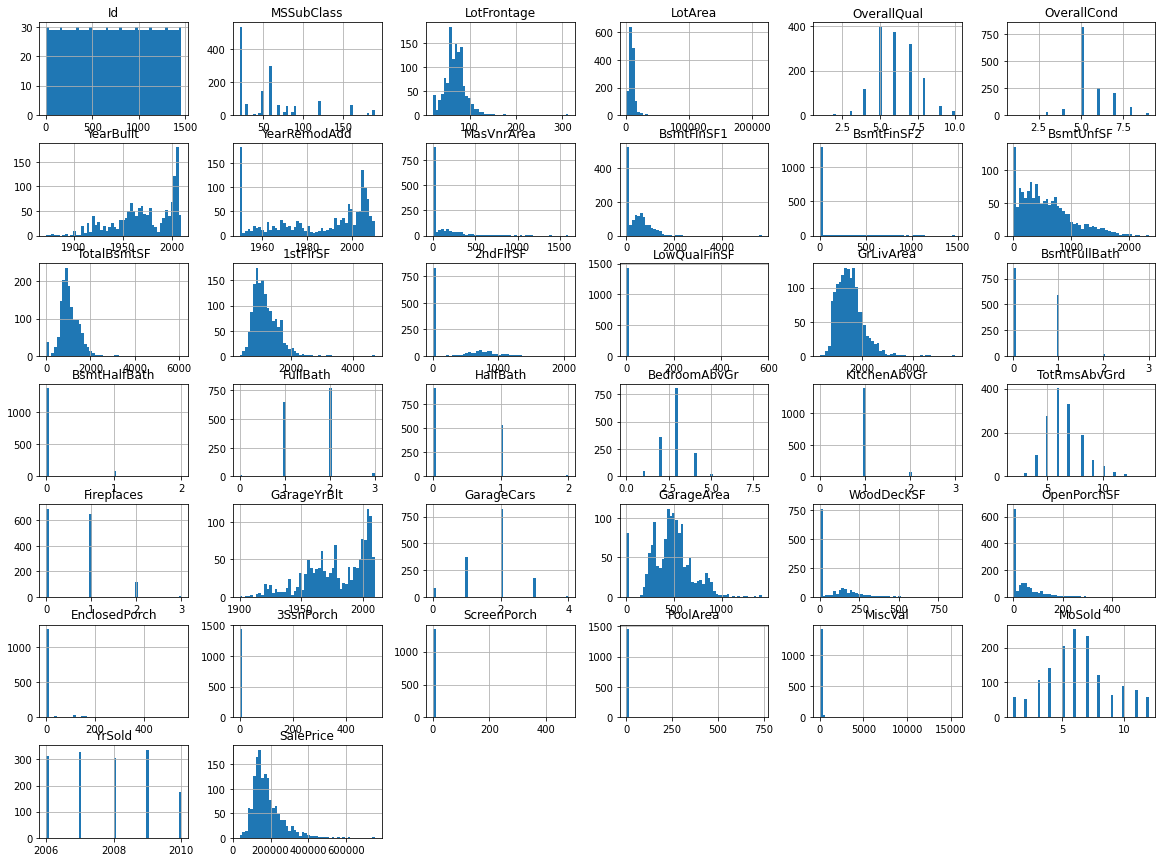

In [5]:
df_hist(train)

In [4]:
num_features = []
cate_features = []
for i in train.columns:
    if i in ('Id', 'SalePrice'):
        continue
    cur = np.array(train[i].values)
    if str(cur.dtype) == 'object':
        cate_features.append(i)
    else:
        num_features.append(i)
print(num_features)
print(cate_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCon

In [5]:
features = gen_features([[i]for i in cate_features], [{'class': OrdinalEncoder, 'handle_unknown':'use_encoded_value', 'unknown_value':np.nan}], prefix="ord_") + gen_features(num_features, classes=[None])
pipe = Pipeline(steps=[
    ('features', DataFrameMapper(features, df_out=True)),
    ('model', LGBMRegressor(verbose=2))
])

In [6]:
train, test = train_test_split(train, test_size=0.1, random_state=42, shuffle=True)
model = pipe.fit(train, train['SalePrice'])

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.885231
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.451752
[LightGBM] [Debug] init for col-wise cost 0.000590 seconds, init for row-wise cost 0.000895 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3305
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 74
[LightGBM] [Info] Start training from score 180704.734399
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[Lig

In [7]:
test_pred = model.predict(test)

In [8]:
for i in zip(test['Id'][:10], test['SalePrice'][:10], test_pred[:10]):
    print(i)

(893, 154500, 142463.75615814372)
(1106, 325000, 318960.1955716395)
(414, 115000, 103191.32478809141)
(523, 159000, 166473.0206985557)
(1037, 315500, 316533.2428426996)
(615, 75500, 78095.64752974788)
(219, 311500, 229090.05802939544)
(1161, 146000, 151108.65497740317)
(650, 84500, 83504.34053993576)
(888, 135500, 131313.90346812457)


In [9]:
pred_m = pipe.predict(pred)
submit = pd.DataFrame({'Id': pred['Id'], 'SalePrice': pred_m})
submit.to_csv('submit.csv', index=False)

In [10]:
submit.head(5)

,Id,SalePrice
0,1461,130523.777803
1,1462,153344.688600
2,1463,179979.443559
3,1464,183459.845097
4,1465,196368.705250
